# Imports

In [ ]:
## Imports
import random
import warnings
import itertools
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import register_matplotlib_converters
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

## Exploratory Data Analysis:

In [2]:
## First glance on dataset
df = pd.read_csv('SNP BSE FMCG.csv')
print(df.head())


         Date      Open      High       Low     Close (High-Low)  (Open-Close)
0  01-01-2024  20507.21  20651.56  20456.08  20567.06     195.48        -59.85
1  29-12-2023  20342.30  20487.66  20288.98  20467.98     198.68       -125.68
2  28-12-2023  20092.59  20317.48  20059.18  20292.76      258.3       -200.17
3  27-12-2023  20016.43  20072.04  19957.22  20044.26     114.82        -27.83
4  26-12-2023  19918.82  19991.86  19884.04  19965.92     107.82        -47.10


In [3]:
## Format date column and set it as index
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.set_index('Date', inplace=True)

In [4]:
## Check for null values
print('Missing values in each column:')
print(df.isnull().sum())

Missing values in each column:
Open            0
High            0
Low             0
Close           0
(High-Low)      0
(Open-Close)    0
dtype: int64


In [ ]:
## Summary of df
print('Summary statistics:')
print(df.describe())

Summary statistics:
               Open          High           Low         Close  (Open-Close)
count   2167.000000   2167.000000   2167.000000   2167.000000   2167.000000
mean   11875.609626  11941.377084  11791.833267  11863.484882     12.124744
std     3129.727978   3142.680673   3121.226148   3133.799755    106.455289
min     7008.600000   7084.530000   6782.150000   7031.390000   -645.260000
25%     9808.305000   9879.285000   9738.655000   9778.355000    -46.500000
50%    11436.410000  11496.330000  11362.820000  11418.590000     11.010000
75%    13604.560000  13658.890000  13523.615000  13589.035000     70.795000
max    20507.210000  20651.560000  20456.080000  20567.060000    634.760000


## FMCG Index Values

In [ ]:
## Value projection accros dataset
fig = make_subplots(rows=2,cols=1, shared_xaxes=True, vertical_spacing=0.1,
                    subplot_titles=('FMCG Index Values', 'Daily Open-Close and High-Low differences'))
fig.add_trace(go.Scatter(x=df.index,y=df['Close'],mode='lines',name='Close Price'), row=1,col=1)
fig.add_trace(go.Scatter(x=df.index,y=df['Open'],mode='lines',name='Open Price'),row=1,col=1)
fig.add_trace(go.Scatter(x=df.index,y=df['High'],mode='lines',name='High Price'),row=1,col=1)
fig.add_trace(go.Scatter(x=df.index,y=df['Low'],mode='lines',name='Low Price'),row=1,col=1)
fig.add_trace(go.Scatter(x=df.index,y=df['(Open-Close)'],mode='lines',name='Open-Close Difference', line=dict(color='blue')),row=2,col=1)
fig.add_trace(go.Scatter(x=df.index,y=df['(High-Low)'],mode='lines',name='High-Low Difference',line=dict(color='red')),row=2,col=1)
fig.update_layout(title='S&P BSE FMCG Index Analysis', xaxis_title='Date', yaxis_title='Value', showlegend=True, template='plotly_dark', height=800)
fig.show()

## Daily returns and Volatility

In [8]:
df = df.sort_values(by='Date', ascending=True)

## Daily returns and volatility
df['Daily Return'] = df['Close'].pct_change()
df['Volatility'] = df['Daily Return'].rolling(window=20).std()

## plot
fig_2 = go.Figure()
fig_2.add_trace(go.Scatter(x=df.index,y=df['Daily Return'],mode='lines',name='Daily Return',line=dict(color='blue')))
fig_2.add_trace(go.Scatter(x=df.index,y=df['Volatility'], mode='lines',name='Volatility (20-day)',line=dict(color='red')))

fig_2.update_layout(title='Daily Returns and Volatility (20-day rolling)',
                  xaxis_title='Date',
                  yaxis_title='Percentage',
                  showlegend=True,
                  template='plotly_dark',
                  height=600)
fig_2.show()


## Bollinger Bands

In [9]:

## Bollinger bands
df['MA20'] = df['Close'].rolling(window=20).mean()
df['Upper Band'] = df['MA20'] + (df['Volatility'] * 2)
df['Lower Band'] = df['MA20'] - (df['Volatility'] * 2)

## plot bollinger
fig_bollinger = go.Figure()
fig_bollinger.add_trace(go.Scatter(x=df.index,y=df['Close'],mode='lines',name='Close Price', line=dict(color='blue')))
fig_bollinger.add_trace(go.Scatter(x=df.index,y=df['MA20'],mode='lines',name='20-day MA', line=dict(color='orange')))
fig_bollinger.add_trace(go.Scatter(x=df.index,y=df['Upper Band'],mode='lines',name='Upper Band', line=dict(color='green')))
fig_bollinger.add_trace(go.Scatter(x=df.index,y=df['Lower Band'],mode='lines',name='Lower Band', line=dict(color='red')))

fig_bollinger.update_layout(title='Bollinger Bands',
                            xaxis_title='Date',
                            yaxis_title='Value',
                            showlegend=True,
                            template='plotly_dark',
                            height=600)
fig_bollinger.show()

## Scaling the data

In [ ]:
## Using MinMaxScaler to further illustrate the data
scaler = MinMaxScaler()

df['Close_scaled'] = scaler.fit_transform(df[['Close']])
df['MA20_scaled'] = df['Close_scaled'].rolling(window=20).mean()
df['STD_scaled'] = df['Close_scaled'].rolling(window=20).std()
df['Upper Band_scaled'] = df['MA20_scaled'] + (df['STD_scaled'] * 2)
df['Lower Band_scaled'] = df['MA20_scaled'] - (df['STD_scaled'] * 2)

fig_bollinger2 = go.Figure()
fig_bollinger2.add_trace(go.Scatter(x=df.index,y=df['Close_scaled'],mode='lines',name='Close Price', line=dict(color='blue')))
fig_bollinger2.add_trace(go.Scatter(x=df.index,y=df['MA20_scaled'],mode='lines',name='20-day MA', line=dict(color='orange')))
fig_bollinger2.add_trace(go.Scatter(x=df.index,y=df['Upper Band_scaled'],mode='lines',name='Upper Band', line=dict(color='green')))
fig_bollinger2.add_trace(go.Scatter(x=df.index,y=df['Lower Band_scaled'],mode='lines',name='Lower Band', line=dict(color='red')))

fig_bollinger2.update_layout(title='Bollinger Bands',
                            xaxis_title='Date',
                            yaxis_title='Value',
                            showlegend=True,
                            template='plotly_dark',
                            height=600)
fig_bollinger2.show()

In [11]:
df['MA50'] = df['Close'].rolling(window=50).mean()
fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=df.index,y=df['Close'],mode='lines',name='Close Value',line=dict(color='blue')))
fig3.add_trace(go.Scatter(x=df.index,y=df['MA20'],mode='lines',name='20-day MA',line=dict(color='orange')))
fig3.add_trace(go.Scatter(x=df.index,y=df['MA50'],mode='lines',name='50-day MA',line=dict(color='green')))
fig3.update_layout(title='Trend Analysis: 20-day and 50-day moving average',
                  xaxis_title='Date',
                  yaxis_title='Value',
                  showlegend=True,
                  template='plotly_dark',
                  height=600)
fig3.show()

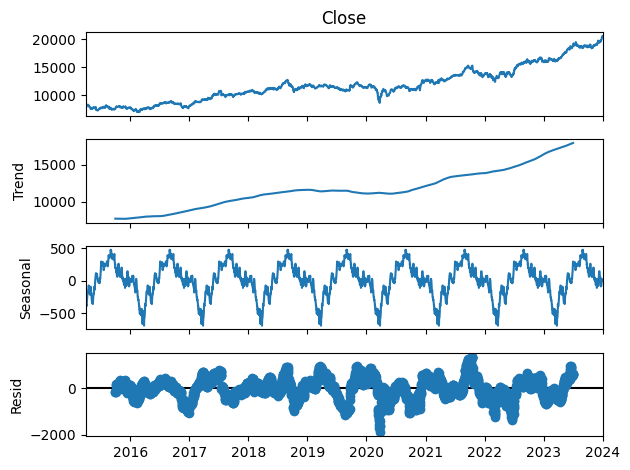

In [12]:

# setting daily frequency
df = df.asfreq('D')

# interpolate missing values
df['Close'] = df['Close'].interpolate()

# seasonal decomp
result = seasonal_decompose(df['Close'], model='additive', period=365)

result.plot()
plt.show()


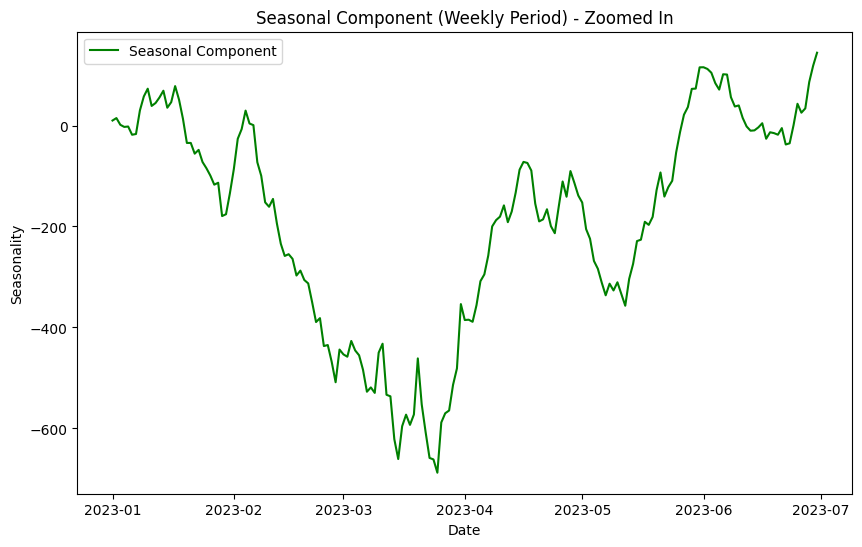

In [13]:
df['Seasonal'] = result.seasonal
df_subset = df.loc['2023-01-01':'2023-06-30']

# Plot the seasonal component for this specific time range
plt.figure(figsize=(10, 6))
plt.plot(df_subset.index, df_subset['Seasonal'], label='Seasonal Component', color='green')
plt.title('Seasonal Component (Weekly Period) - Zoomed In')
plt.xlabel('Date')
plt.ylabel('Seasonality')
plt.legend()
plt.show()

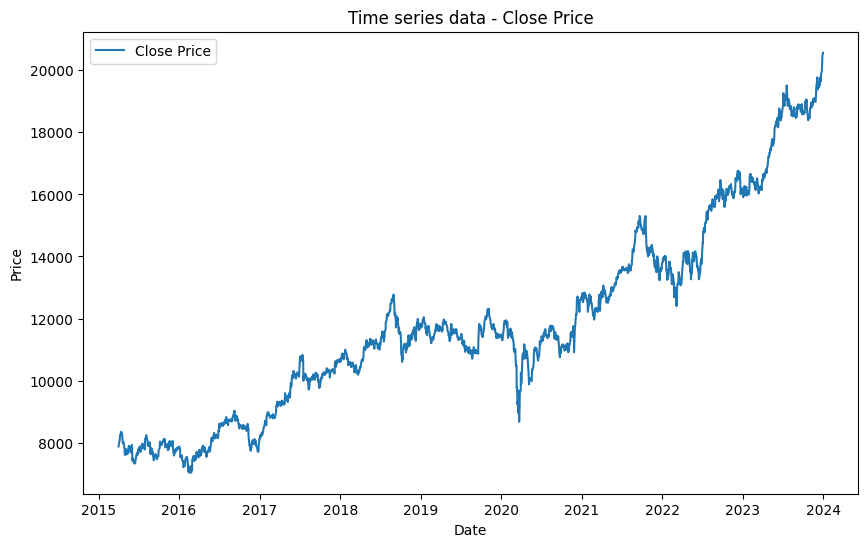

In [14]:
register_matplotlib_converters()

plt.figure(figsize=(10,6))
plt.plot(df.index,df['Close'],label='Close Price')
plt.title('Time series data - Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Forecasting Models (ARIMA - Exponential Smoothing):

In [15]:
# Data splitting
train_size = int(len(df)*0.8)
train_data = df['Close'][:train_size]
test_data = df['Close'][train_size:]

# ARIMA model:

In [ ]:
# Initiating the ARIMA model
model = ARIMA(train_data, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2558
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -14885.516
Date:                Tue, 12 Nov 2024   AIC                          29783.032
Time:                        20:48:21   BIC                          29818.112
Sample:                    04-01-2015   HQIC                         29795.753
                         - 04-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0803      0.011      7.513      0.000       0.059       0.101
ar.L2          0.0646      0.012      5.250      0.000       0.040       0.089
ar.L3         -0.0116      0.014     -0.824      0.4

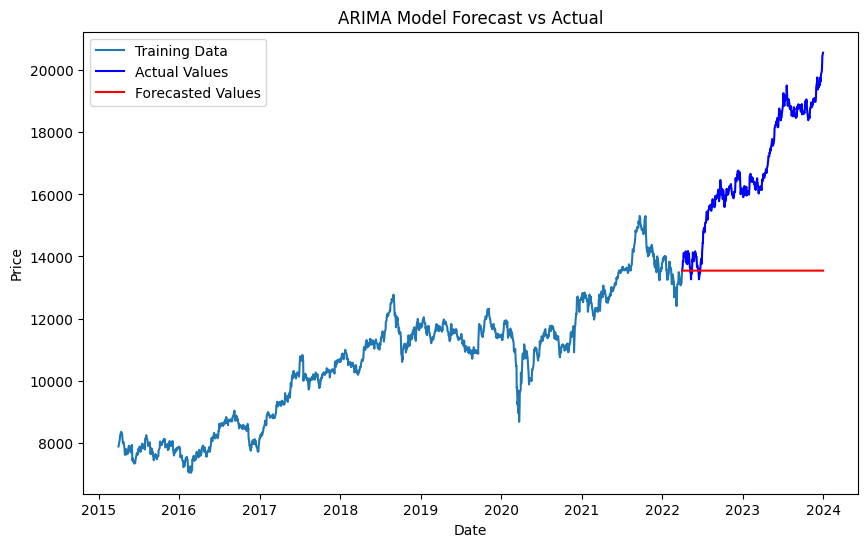

In [17]:
forecast = model_fit.forecast(steps=len(test_data))

plt.figure(figsize=(10,6))
plt.plot(train_data.index,train_data,label='Training Data')
plt.plot(test_data.index,test_data,label='Actual Values', color='blue')
plt.plot(test_data.index,forecast,label='Forecasted Values', color='red')
plt.title('ARIMA Model Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [18]:
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

Mean Squared Error: 13753749.38558783
Root Mean Squared Error: 3708.6047761372242


In [ ]:
# refining the ARIMA model using the Dickey-Fuller test
result = adfuller(df['Close'].dropna())

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('Critical Value (%s): %f' % (key, value))

ADF Statistic: 0.876084
p-value: 0.992770
Critical Value (1%): -3.432398
Critical Value (5%): -2.862445
Critical Value (10%): -2.567252


By looking at the p-value we deduce that first-order differencing is needed.

In [20]:
df['Close_diff'] = df['Close'].diff().dropna()

result = adfuller(df['Close_diff'].dropna())

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('Critical Value (%s): %f' % (key, value))

ADF Statistic: -36.136029
p-value: 0.000000
Critical Value (1%): -3.432398
Critical Value (5%): -2.862445
Critical Value (10%): -2.567252


Now we know that only 1st order differencing is sufficient to make the data stationary, so the 'd' value should be 1.


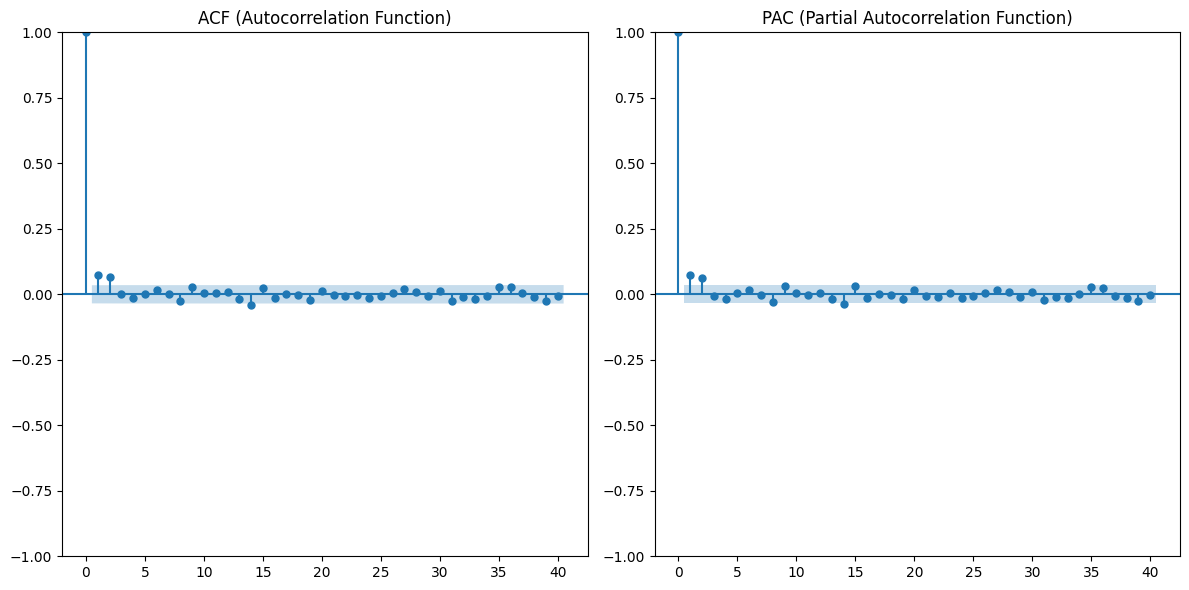

In [21]:

plt.figure(figsize=(12,6))
plt.subplot(121)
plot_acf(df['Close_diff'].dropna(), lags=40, ax=plt.gca())
plt.title('ACF (Autocorrelation Function)')

plt.subplot(122)
plot_pacf(df['Close_diff'].dropna(), lags=40, ax=plt.gca())
plt.title('PAC (Partial Autocorrelation Function)')

plt.tight_layout()
plt.show()

In [ ]:
# Using Grid search to optimize ARIMA model Parameters

warnings.filterwarnings("ignore")

p = d = q = range(0,4)

pdq = list(itertools.product(p,d,q))
best_aic = float('inf')
best_order = None

for param in pdq:
    try:
        model = ARIMA(df['Close_diff'], order = param)
        model_fit = model.fit()
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_order = param
    except:
        continue
print(f'Best ARIMA order: {best_order} with AIC: {best_aic}')

Best ARIMA order: (0, 0, 2) with AIC: 37469.07083597762


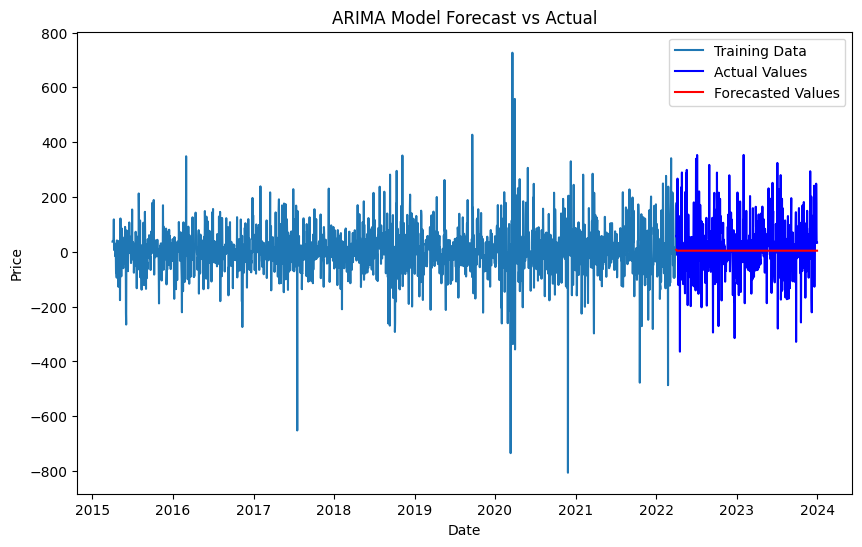

Mean Squared Error: 9288.810319527262
Root Mean Squared Error: 96.3784743577489
Error Percentage: 0.81%


In [23]:
model = ARIMA(df['Close_diff'], order=(0,0,2))
model_fit = model.fit()

train_size = int(len(df)*0.8)
train_data_diff = df['Close_diff'][:train_size]
test_data_diff = df['Close_diff'][train_size:]

forecast = model_fit.forecast(steps=len(test_data))

plt.figure(figsize=(10,6))
plt.plot(train_data_diff.index,train_data_diff,label='Training Data')
plt.plot(test_data_diff.index,test_data_diff,label='Actual Values', color='blue')
plt.plot(test_data_diff.index,forecast,label='Forecasted Values', color='red')
plt.title('ARIMA Model Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

mse = mean_squared_error(test_data_diff, forecast)
rmse = np.sqrt(mse)
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f"Error Percentage: {round(((rmse / df['Close'].mean())*100),2)}%")

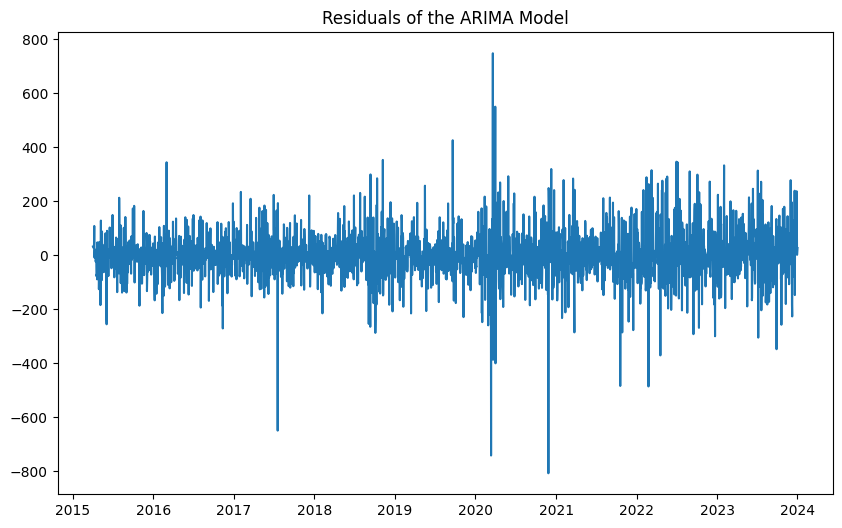

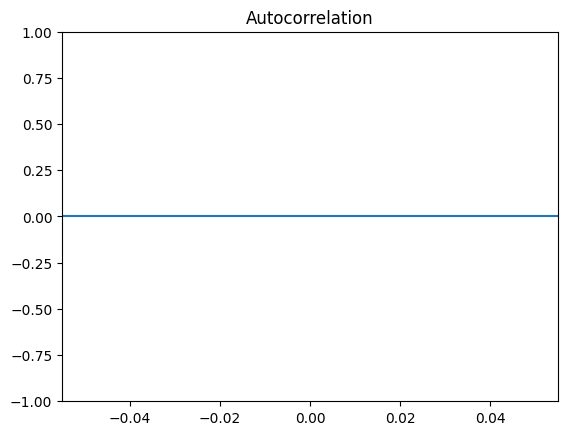

In [ ]:
# residual plot
residuals = model_fit.resid
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals of the ARIMA Model')
plt.show()

plot_acf(residuals, lags=40)
plt.show()

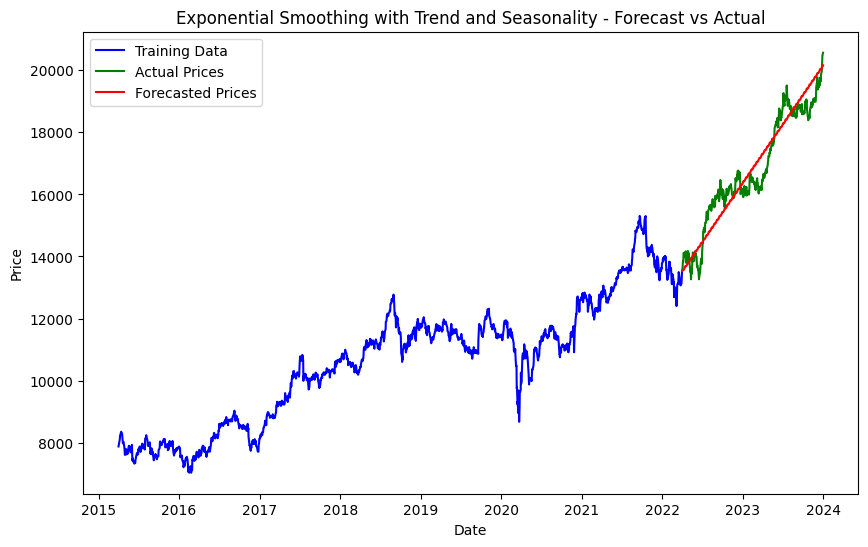

Mean Squared Error: 293658.335051542
Root Mean Squared Error: 541.9025143432552
Error Percentage: 4.57%
AIC: 22763.938571820254


In [26]:
model = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=12)
model1_fit = model.fit()
forecast = model1_fit.forecast(steps=len(test_data))
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data, label='Training Data', color='blue')
plt.plot(test_data.index, test_data, label='Actual Prices', color='green')
plt.plot(test_data.index, forecast, label='Forecasted Prices', color='red')
plt.title('Exponential Smoothing with Trend and Seasonality - Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
e_smoothing_aic = model1_fit.aic
# Evaluate the model using Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Error Percentage: {round(((rmse / df['Close'].mean())*100),2)}%")
print(f"AIC: {e_smoothing_aic}")

Seeing as how ARIMA models are a better fit when it comes to stock market data, and how the ARIMA model in this case was more accurate in it's forecasts than the Exponential Smoothing model, we will go forward with the ARIMA model.

# M.L model (X.G. Boost)

In [27]:
data = df['Close']

def create_lagged_features(data, lag):
    df_lagged = pd.DataFrame()
    for i in range(1, lag+1):
        df_lagged[f'lag_{i}'] = data.shift(i)
    df_lagged['target'] = data
    return df_lagged.dropna()

lag = 7
data_lagged = create_lagged_features(data, lag)
print (data_lagged.head())


                  lag_1    lag_2     lag_3     lag_4     lag_5     lag_6  \
Date                                                                       
2015-04-08  8114.610000  8062.78  8025.732  7988.684  7951.636  7914.588   
2015-04-09  8232.800000  8114.61  8062.780  8025.732  7988.684  7951.636   
2015-04-10  8239.340000  8232.80  8114.610  8062.780  8025.732  7988.684   
2015-04-11  8272.330000  8239.34  8232.800  8114.610  8062.780  8025.732   
2015-04-12  8298.913333  8272.33  8239.340  8232.800  8114.610  8062.780   

               lag_7       target  
Date                               
2015-04-08  7877.540  8232.800000  
2015-04-09  7914.588  8239.340000  
2015-04-10  7951.636  8272.330000  
2015-04-11  7988.684  8298.913333  
2015-04-12  8025.732  8325.496667  


In [ ]:
# train-test split
train_size = int(len(data_lagged)*0.8)
train_data = data_lagged[:train_size]
test_data = data_lagged[train_size:]
x_train, y_train = train_data.drop('target', axis = 1), train_data['target']
x_test, y_test = test_data.drop('target', axis = 1), test_data['target']

In [ ]:
model = xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators = 10, learning_rate = 0.1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [30]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')
percentage_error = (rmse / y_test.mean()) * 100
print(f'Error Percentage: {percentage_error:.2f}%')

RMSE: 3875.2635482983906
Error Percentage: 23.08%


# Refining XGBoost

## Grid Search for optimum parameters

In [ ]:

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror'), param_grid, cv=3)
grid.fit(x_train, y_train)
print(f"Best Parameters: {grid.best_params_}")

Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}


In [32]:
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(x_train):
    x_train_split, x_test_split = x_train.iloc[train_index], x_train.iloc[test_index]
    y_train_split, y_test_split = y_train.iloc[train_index], y_train.iloc[test_index]
    

In [33]:
model = xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators = 200, learning_rate = 0.2, max_depth = 3)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')
percentage_error = (rmse / y_test.mean()) * 100
print(f'Error Percentage: {percentage_error:.2f}%')

RMSE: 2579.1879962125904
Error Percentage: 15.36%


## Time series split

In [34]:

def create_lagged_features1(data, lag):
    df_lagged = pd.DataFrame()
    for i in range(1, lag + 1):
        df_lagged[f'lag_{i}'] = data.shift(i)
    df_lagged['target'] = data  # Target value (current 'Close' price)
    return df_lagged.dropna()

# Create lag features with a window size of 7
data_lagged = create_lagged_features1(df['Close'], lag=7)

# Separate features and target
X = data_lagged.drop('target', axis=1)
y = data_lagged['target']

# Initialize TimeSeriesSplit 
tscv = TimeSeriesSplit(n_splits=5)

# Store RMSE for each fold
rmse_scores = []

# Perform cross-validation using TimeSeriesSplit
for train_index, test_index in tscv.split(X):
    # Split the data into train and test sets for each fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize the XGBoost regressor
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.2, max_depth=3)

    # Train the model on the current fold
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate RMSE for the current fold
    rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
    rmse_scores.append(rmse)

    print(f'Fold RMSE: {rmse}')

# Calculate the average RMSE across all folds
average_rmse = np.mean(rmse_scores)
print(f'Average RMSE across all folds: {average_rmse}')


Fold RMSE: 1113.0835463011172
Fold RMSE: 706.5227214663004
Fold RMSE: 128.55913073954713
Fold RMSE: 1150.9748565502457
Fold RMSE: 2780.693878165222
Average RMSE across all folds: 1175.9668266444864


In [35]:
final_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.2, max_depth=3)
final_model.fit(X, y)

# Use the last 7 values to forecast the next value
last_lag = X.iloc[-1].values.reshape(1, -1)
forecast = final_model.predict(last_lag)
print(f'Forecasted Value: {forecast[0]}')

Forecasted Value: 20309.951171875


## RMSE testing after tuning

In [36]:
final_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.2, max_depth=3)
final_model.fit(X, y)

# Use the last 7 values (or appropriate lag size) to forecast the next value
last_lag = X.iloc[-1].values.reshape(1, -1)
forecast = final_model.predict(last_lag)[0]
print(f'Forecasted Value: {forecast}')

# Evaluate performance with error percentage (MAPE and RMSE-based error percentage)
# Predict on the entire dataset to compare forecasts with actuals
y_pred = final_model.predict(X)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f'RMSE: {rmse}')

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y - y_pred) / y)) * 100
print(f'MAPE: {mape:.2f}%')

# Calculate RMSE-based Error Percentage
error_percentage = (rmse / y.mean()) * 100
print(f'Error Percentage: {error_percentage:.2f}%')

Forecasted Value: 20309.951171875
RMSE: 72.11443565980152
MAPE: 0.45%
Error Percentage: 0.61%
